In [1]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
import random
import time
import math
import d2l
import os

from mxnet import autograd, np, npx, gluon, init
from mxnet.gluon import loss as gloss
from mxnet.gluon import rnn
from mxnet.gluon import nn
npx.set_np()

# 11. Optimization Algorithms
If you read the book in sequence up to this point you already used a number of advanced optimization algorithms to train deep learning models. They were the tools that allowed us to continue updating model parameters and to minimize the value of the loss function, as evaluated on the training set. Indeed, anyone content with treating optimization as a black box device to minimize objective functions in a simple setting might well content oneself with the knowledge that there exists an array of incantations of such a procedure (with names such as `Adam`, `NAG`, or `SGD`).

To do well, however, some deeper knowledge is required. Optimization algorithms are important for deep learning. On one hand, training a complex deep learning model can take hours, days, or even weeks. The performance of the optimization algorithm directly affects the model's training efficiency. On the other hand, understanding the principles of different optimization algorithms and the role of their parameters will enable us to tune the hyperparameters in a targeted manner to improve the performance of deep learning models.

In this chapter, we explore common deep learning optimization algorithms in depth. Almost all optimization problems arising in deep learning are nonconvex. Nonetheless, the design and analysis of algorithms in the context of convex problems has proven to be very instructive. It is for that reason that this section includes a primer on convex optimization and the proof for a very simple stochastic gradient descent algorithm on a convex objective function.

## 11.1 Optimization and Deep Learning
In this section, we will discuss the relationship between optimization and deep learning as well as the challenges of using optimization in deep learning. For a deep learning problem, we will usually define a loss function first. Once we have the loss function, we can use an optimization algorithm in attempt to minimize the loss. In optimization, a loss function is often referred to as the objective function of the optimization problem. By tradition and convention most optimization algorithms are concerned with minimization. If we ever need to maximize an objective there is a simple solution: just flip the sign on the objective.

### 11.1.1 Optimization and Estimation
Although optimization provides a way to minimize the loss function for deep learning, in essence, the goals of optimization and deep learning are fundamentally different. The former is primarily concerned with minimizing an objective whereas the latter is concerned with finding a suitable model, given a finite amount of data. In `Section 4.4`, we discussed the difference between these two goals in detail. For instance, training error and generalization error generally differ: since the objective function of the optimization algorithm is usually a loss function based on the training dataset, the goal of optimization is to reduce the training error. However, the goal of statistical inference (and thus of deep learning) is to reduce the generalization error. To accomplish the latter we need to pay attention to overfitting in addition to using the optimization algorithm to reduce the training error. We begin by importing a few libraries with a function to annotate in a figure.

In [2]:
#@save
def annotate(text, xy, xytext):
    d2l.plt.gca().annotate(text, xy=xy, xytext=xytext, arrowprops=dict(arrowstyle='->'))

The graph below illustrates the issue in some more detail. Since we have only a finite amount of data the minimum of the training error may be at a different location than the minimum of the expected error (or of the test error).

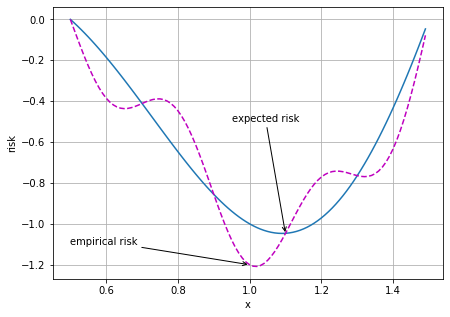

In [3]:
def f(x): return x * np.cos(np.pi * x)
def g(x): return f(x) + 0.2 * np.cos(5 * np.pi * x)

d2l.set_figsize((4.5, 2.5))
x = np.arange(0.5, 1.5, 0.01)
d2l.plot(x, [f(x), g(x)], 'x', 'risk')
annotate('empirical risk', (1.0, -1.2), (0.5, -1.1))
annotate('expected risk', (1.1, -1.05), (0.95, -0.5))

### 11.1.2 Optimization Challenges in Deep Learning
In this chapter, we are going to focus specifically on the performance of the optimization algorithm in minimizing the objective function, rather than a model's generalization error. In `Section 3.1` we distinguished between `analytical solutions` and `numerical solutions` in optimization problems. In deep learning, most objective functions are complicated and do not have analytical solutions. Instead, we must use numerical optimization algorithms. The optimization algorithms below all fall into this category.

There are many challenges in deep learning optimization. Some of the most vexing ones are `local minima`, `saddle points` and `vanishing gradients`. Let us have a look at a few of them.

##### Local Minima
For the objective function $f(x)$, if the value of $f(x)$ at $x$ is smaller than the values of $f(x)$ at any other points in the vicinity of $x$, then $f(x)$ could be a `local minimum`. If the value of $f(x)$ at $x$ is the minimum of the objective function over the entire domain, then $f(x)$ is the `global minimum`.

For example, given the function

$$f(x) = x \cdot \text{cos}(\pi x) \textrm{, for } -1.0 \leq x \leq 2.0,$$

we can approximate the local minimum and global minimum of this function.

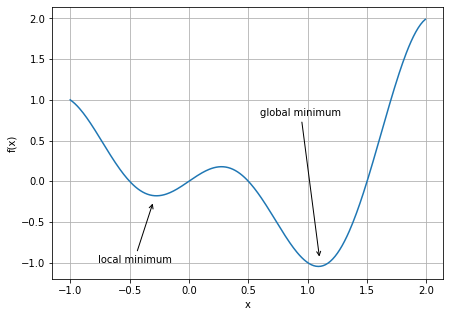

In [4]:
x = np.arange(-1.0, 2.0, 0.01)
d2l.plot(x, [f(x), ], 'x', 'f(x)')
annotate('local minimum', (-0.3, -0.25), (-0.77, -1.0))
annotate('global minimum', (1.1, -0.95), (0.6, 0.8))

The objective function of deep learning models usually has many local optima. When the numerical solution of an optimization problem is near the local optimum, the numerical solution obtained by the final iteration may only minimize the objective function locally, rather than globally, as the gradient of the objective function's solutions approaches or becomes zero. Only some degree of noise might knock the parameter out of the local minimum. In fact, this is one of the beneficial properties of stochastic gradient descent where the natural variation of gradients over minibatches is able to dislodge the parameters from local minima.

##### Saddle Points
Besides local minima, `saddle points` are another reason for gradients to vanish. A saddle point is any location where all gradients of a function vanish but which is neither a global nor a local minimum. Consider the function $f(x) = x^3$. Its first and second derivative vanish for $x=0$. Optimization might stall at the point, even though it is not a minimum.

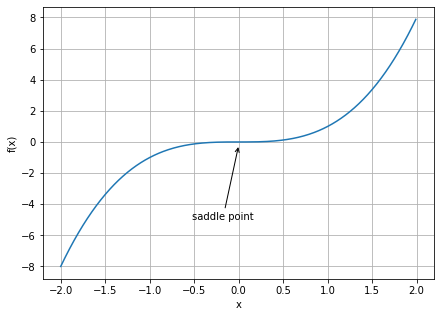

In [5]:
x = np.arange(-2.0, 2.0, 0.01)
d2l.plot(x, [x**3], 'x', 'f(x)')
annotate('saddle point', (0, -0.2), (-0.52, -5.0))

Saddle points in higher dimensions are even more insidious, as the example below shows. Consider the function $f(x, y) = x^2 - y^2$. It has its saddle point at $(0, 0)$. This is a maximum with respect to $y$ and a minimum with respect to $x$. Moreover, it looks like a saddle, which is where this mathematical property got its name.

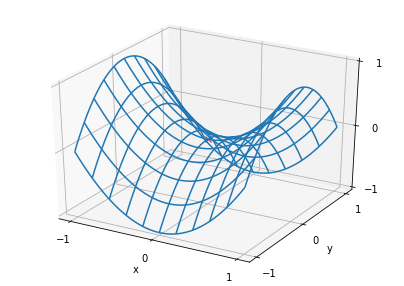

In [6]:
x, y = np.meshgrid(np.linspace(-1, 1, 101), np.linspace(-1, 1, 101), indexing='ij')

z = x**2 - y**2

ax = d2l.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 10, 'cstride': 10})
ax.plot([0], [0], [0], 'rx')
ticks = [-1, 0, 1]
d2l.plt.xticks(ticks)
d2l.plt.yticks(ticks)
ax.set_zticks(ticks)
d2l.plt.xlabel('x')
d2l.plt.ylabel('y');

We assume that the input of a function is a $k$-dimensional vector and its output is a scalar, so its Hessian matrix will have $k$ eigenvalues (refer to `Section 18.1`). The solution of the function could be a local minimum, a local maximum, or a saddle point at a position where the function gradient is zero:
+ When the eigenvalues of the function's Hessian matrix at the zero-gradient position are all positive, we have a local minimum for the function
+ When the eigenvalues of the function's Hessian matrix at the zero-gradient position are all negative, we have a local maximum for the function
+ When the eigenvalues of the function's Hessian matrix at the zero-gradient position are negative and positive, we have a saddle point for the function

For high-dimensional problems the likelihood that at least some of the eigenvalues are negative is quite high. This makes saddle points more likely than local minima. We will discuss some exceptions to this situation in the next section when introducing convexity. In short, convex functions are those where the eigenvalues of the Hessian are never negative. Sadly, though, most deep learning problems do not fall into this category. Nonetheless it is a great tool to study optimization algorithms.

##### Vanishing Gradients
Probably the most insidious problem to encounter are vanishing gradients. For instance, assume that we want to minimize the function $f(x) = \tanh(x)$ and we happen to get started at $x = 4$. As we can see, the gradient of $f$ is close to nil. More specifically $f'(x) = 1 - \tanh^2(x)$ and thus $f'(4) = 0.0013$. Consequently optimization will get stuck for a long time before we make progress. This turns out to be one of the reasons that training deep learning models was quite tricky prior to the introduction of the `ReLU` activation function.

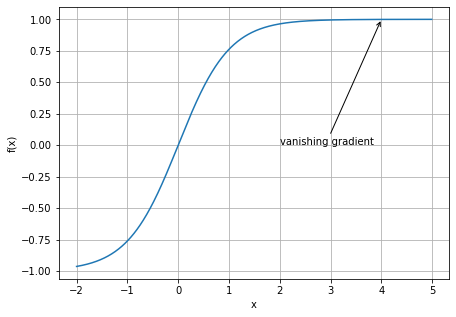

In [7]:
x = np.arange(-2.0, 5.0, 0.01)
d2l.plot(x, [np.tanh(x)], 'x', 'f(x)')
annotate('vanishing gradient', (4, 1), (2, 0.0))

As we saw, optimization for deep learning is full of challenges. Fortunately there exists a robust range of algorithms that perform well and that are easy to use even for beginners. Furthermore, it is not really necessary to find the best solution. Local optima or even approximate solutions thereof are still very useful.

##### Summary
+ Minimizing the training error does not guarantee that we find the best set of parameters to minimize the expected error.
+ The optimization problems may have many local minima.
+ The problem may have even more saddle points, as generally the problems are not convex.
+ Vanishing gradients can cause optimization to stall. Often a reparameterization of the problem helps. Good initialization of the parameters can be beneficial, too.

##### Exercises
1. Consider a simple multilayer perceptron with a single hidden layer of, say, $d$ dimensions in the hidden layer and a single output. Show that for any local minimum there are at least $d!$ equivalent solutions that behave identically.
2. Assume that we have a symmetric random matrix $\mathbf{M}$ where the entries $M_{ij} = M_{ji}$ are each drawn from some probability distribution $p_{ij}$. Furthermore assume that $p_{ij}(x) = p_{ij}(-x)$, i.e., that the distribution is symmetric (see e.g., (`Wigner, 1958`) for details).
    + Prove that the distribution over eigenvalues is also symmetric. That is, for any eigenvector $\mathbf{v}$ the probability that the associated eigenvalue $\lambda$ satisfies $P(\lambda > 0) = P(\lambda < 0)$.
    + Why does the above not imply $P(\lambda > 0) = 0.5$?
3. What other challenges involved in deep learning optimization can you think of?
4. Assume that you want to balance a (real) ball on a (real) saddle.
    + Why is this hard?
    + Can you exploit this effect also for optimization algorithms?


## 11.2 Convexity
Convexity plays a vital role in the design of optimization algorithms. This is largely due to the fact that it is much easier to analyze and test algorithms in this context. In other words, if the algorithm performs poorly even in the convex setting we should not hope to see great results otherwise. Furthermore, even though the optimization problems in deep learning are generally nonconvex, they often exhibit some properties of convex ones near local minima. This can lead to exciting new optimization variants such as (`Izmailov et al., 2018`).

### 11.2.1 Basics
Let us begin with the basics.

##### Sets
Sets are the basis of convexity. Simply put, a set $X$ in a vector space is convex if for any $a, b \in X$ the line segment connecting $a$ and $b$ is also in $X$. In mathematical terms this means that for all $\lambda \in [0, 1]$ we have

$$\lambda \cdot a + (1-\lambda) \cdot b \in X \text{ whenever } a, b \in X.$$

This sounds a bit abstract. Consider the picture `Fig. 11.2.1`. The first set is not convex since there are line segments that are not contained in it. The other two sets suffer no such problem.

<img src="images/11_01.png" style="width:500px;"/>

Definitions on their own are not particularly useful unless you can do something with them. In this case we can look at unions and intersections as shown in `Fig. 11.2.2`. Assume that $X$ and $Y$ are convex sets. Then $X \cap Y$ is also convex. To see this, consider any $a, b \in X \cap Y$. Since $X$ and $Y$ are convex, the line segments connecting $a$ and $b$ are contained in both $X$ and $Y$. Given that, they also need to be contained in $X \cap Y$, thus proving our first theorem.

<img src="images/11_02.png" style="width:500px;"/>

We can strengthen this result with little effort: given convex sets $X_i$, their intersection $\cap_{i} X_i$ is convex. To see that the converse is not true, consider two disjoint sets $X \cap Y = \emptyset$. Now pick $a \in X$ and $b \in Y$. The line segment in `Fig. 11.2.3` connecting $a$ and $b$ needs to contain some part that is neither in $X$ nor $Y$, since we assumed that $X \cap Y = \emptyset$. Hence the line segment is not in $X \cup Y$ either, thus proving that in general unions of convex sets need not be convex.

<img src="images/11_03.png" style="width:380px;"/>

Typically the problems in deep learning are defined on convex domains. For instance $\mathbb{R}^d$ is a convex set (after all, the line between any two points in $\mathbb{R}^d$ remains in $\mathbb{R}^d$). In some cases we work with variables of bounded length, such as balls of radius $r$ as defined by ${\mathbf{x} | \mathbf{x} \in \mathbb{R}^d \text{ and } |\mathbf{x}|_2 \leq r}$.

##### Functions
Now that we have convex sets we can introduce convex functions $f$. Given a convex set $X$ a function defined on it $f: X \to \mathbb{R}$ is convex if for all $x, x' \in X$ and for all $\lambda \in [0, 1]$ we have

$$\lambda f(x) + (1-\lambda) f(x') \geq f(\lambda x + (1-\lambda) x').$$

To illustrate this let us plot a few functions and check which ones satisfy the requirement. We need to import a few libraries.

Let us define a few functions, both convex and nonconvex.

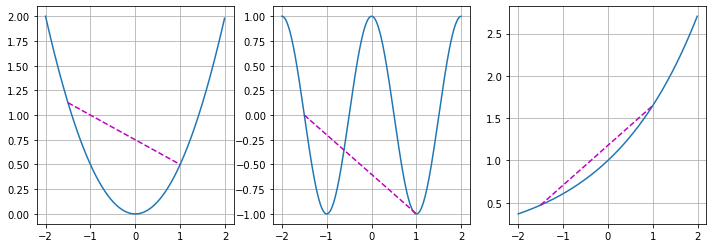

In [8]:
def f(x):
    return 0.5 * x**2  # Convex

def g(x):
    return np.cos(np.pi * x)  # Nonconvex

def h(x):
    return np.exp(0.5 * x)  # Convex

x, segment = np.arange(-2, 2, 0.01), np.array([-1.5, 1])
d2l.use_svg_display()
_, axes = d2l.plt.subplots(1, 3, figsize=(12, 4))

for ax, func in zip(axes, [f, g, h]):
    d2l.plot([x, segment], [func(x), func(segment)], axes=ax)

As expected, the `cosine` function is nonconvex, whereas the parabola and the exponential function are. Note that the requirement that $X$ is a convex set is necessary for the condition to make sense. Otherwise the outcome of $f(\lambda x + (1-\lambda) x')$ might not be well defined. Convex functions have a number of desirable properties.

##### Jensen's Inequality
One of the most useful tools is Jensen's inequality. It amounts to a generalization of the definition of convexity:

$$\begin{aligned} \sum_i \alpha_i f(x_i) & \geq f\left(\sum_i \alpha_i x_i\right) \text{ and } E_x[f(x)] & \geq f\left(E_x[x]\right), \end{aligned}$$

where $\alpha_i$ are nonnegative real numbers such that $\sum_i \alpha_i = 1$. In other words, the expectation of a convex function is larger than the convex function of an expectation. To prove the first inequality we repeatedly apply the definition of convexity to one term in the sum at a time. The expectation can be proven by taking the limit over finite segments.

One of the common applications of Jensen's inequality is with regard to the log-likelihood of partially observed random variables. That is, we use

$$E_{y \sim P(y)}[-\log P(x \mid y)] \geq -\log P(x).$$

This follows since $\int P(y) P(x \mid y) dy = P(x)$. This is used in variational methods. Here $y$ is typically the unobserved random variable, $P(y)$ is the best guess of how it might be distributed and $P(x)$ is the distribution with $y$ integrated out. For instance, in clustering $y$ might be the cluster labels and $P(x \mid y)$ is the generative model when applying cluster labels.

### 11.2.2 Properties
Convex functions have a few useful properties. We describe them as follows.

##### No Local Minima
In particular, convex functions do not have local minima. Let us assume the contrary and prove it wrong. If $x \in X$ is a local minimum there exists some neighborhood of $x$ for which $f(x)$ is the smallest value. Since $x$ is only a local minimum there has to be another $x' \in X$ for which $f(x') < f(x)$. However, by convexity the function values on the entire line $\lambda x + (1-\lambda) x'$ have to be less than $f(x')$ since for $\lambda \in [0, 1)$

$$f(x) > \lambda f(x) + (1-\lambda) f(x') \geq f(\lambda x + (1-\lambda) x').$$

This contradicts the assumption that $f(x)$ is a local minimum. For instance, the function $f(x) = (x+1) (x-1)^2$ has a local minimum for $x=1$. However, it is not a global minimum.

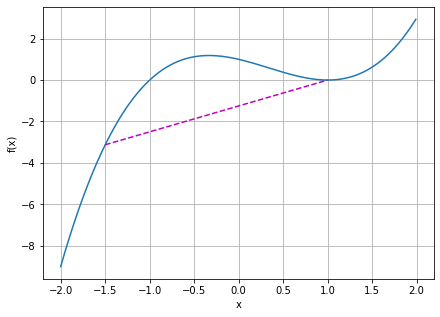

In [9]:
def f(x):
    return (x-1)**2 * (x+1)

d2l.set_figsize()
d2l.plot([x, segment], [f(x), f(segment)], 'x', 'f(x)')

The fact that convex functions have no local minima is very convenient. It means that if we minimize functions we cannot "get stuck". Note, though, that this does not mean that there cannot be more than one global minimum or that there might even exist one. For instance, the function $f(x) = \mathrm{max}(|x|-1, 0)$ attains its minimum value over the interval $[-1, 1]$. Conversely, the function $f(x) = \exp(x)$ does not attain a minimum value on $\mathbb{R}$. For $x \to -\infty$ it asymptotes to $0$, however there is no $x$ for which $f(x) = 0$.

##### Convex Functions and Sets
Convex functions define convex sets as below-sets. They are defined as

$$S_b := {x | x \in X \text{ and } f(x) \leq b}.$$

Such sets are convex. Let us prove this quickly. Remember that for any $x, x' \in S_b$ we need to show that $\lambda x + (1-\lambda) x' \in S_b$ as long as $\lambda \in [0, 1]$. But this follows directly from the definition of convexity since $f(\lambda x + (1-\lambda) x') \leq \lambda f(x) + (1-\lambda) f(x') \leq b$.

Have a look at the function $f(x, y) = 0.5 x^2 + \cos(2 \pi y)$ below. It is clearly nonconvex. The level sets are correspondingly nonconvex. In fact, they are typically composed of disjoint sets.

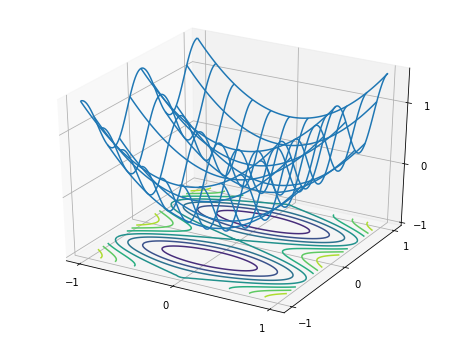

In [10]:
x, y = np.meshgrid(np.linspace(-1, 1, 101), np.linspace(-1, 1, 101), indexing='ij')

z = x**2 + 0.5 * np.cos(2 * np.pi * y)

# Plot the 3D surface
d2l.set_figsize((8, 6))
ax = d2l.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 10, 'cstride': 10})
ax.contour(x, y, z, offset=-1)
ax.set_zlim(-1, 1.5)

# Adjust labels
for func in [d2l.plt.xticks, d2l.plt.yticks, ax.set_zticks]:
    func([-1, 0, 1])

##### Derivatives and Convexity
Whenever the second derivative of a function exists it is very easy to check for convexity. All we need to do is check whether $\partial_x^2 f(x) \succeq 0$, i.e., whether all of its eigenvalues are nonnegative. For instance, the function $f(\mathbf{x}) = \frac{1}{2} |\mathbf{x}|^2_2$ is convex since $\partial_{\mathbf{x}}^2 f = \mathbf{1}$, i.e., its derivative is the identity matrix.

The first thing to realize is that we only need to prove this property for one-dimensional functions. After all, in general we can always define some function $g(z) = f(\mathbf{x} + z \cdot \mathbf{v})$. This function has the first and second derivatives $g' = (\partial_{\mathbf{x}} f)^\top \mathbf{v}$ and $g'' = \mathbf{v}^\top (\partial^2_{\mathbf{x}} f) \mathbf{v}$ respectively. In particular, $g'' \geq 0$ for all $\mathbf{v}$ whenever the Hessian of $f$ is positive semidefinite, i.e., whenever all of its eigenvalues are greater equal than zero. Hence back to the scalar case.

To see that $f''(x) \geq 0$ for convex functions we use the fact that

$$\frac{1}{2} f(x + \epsilon) + \frac{1}{2} f(x - \epsilon) \geq f\left(\frac{x + \epsilon}{2} + \frac{x - \epsilon}{2}\right) = f(x).$$

Since the second derivative is given by the limit over finite differences it follows that

$$f''(x) = \lim_{\epsilon \to 0} \frac{f(x+\epsilon) + f(x - \epsilon) - 2f(x)}{\epsilon^2} \geq 0.$$

To see that the converse is true we use the fact that $f'' \geq 0$ implies that $f'$ is a monotonically increasing function. Let $a < x < b$ be three points in $\mathbb{R}$. We use the mean value theorem to express

$$\begin{aligned} f(x) - f(a) & = (x-a) f'(\alpha) \text{ for some } \alpha \in [a, x] \text{ and } \ f(b) - f(x) & = (b-x) f'(\beta) \text{ for some } \beta \in [x, b]. \end{aligned}$$

By monotonicity $f'(\beta) \geq f'(\alpha)$, hence

$$\begin{aligned} f(b) - f(a) & = f(b) - f(x) + f(x) - f(a) \ & = (b-x) f'(\beta) + (x-a) f'(\alpha) \ & \geq (b-a) f'(\alpha). \end{aligned}$$

By geometry it follows that $f(x)$ is below the line connecting $f(a)$ and $f(b)$, thus proving convexity. We omit a more formal derivation in favor of a graph below.

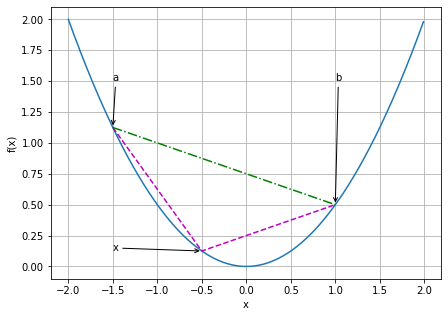

In [11]:
def f(x):
    return 0.5 * x**2

x = np.arange(-2, 2, 0.01)
axb, ab = np.array([-1.5, -0.5, 1]), np.array([-1.5, 1])

d2l.set_figsize()
d2l.plot([x, axb, ab], [f(x) for x in [x, axb, ab]], 'x', 'f(x)')
d2l.annotate('a', (-1.5, f(-1.5)), (-1.5, 1.5))
d2l.annotate('b', (1, f(1)), (1, 1.5))
d2l.annotate('x', (-0.5, f(-0.5)), (-1.5, f(-0.5)))

### 11.2.3 Constraints
One of the nice properties of convex optimization is that it allows us to handle constraints efficiently. That is, it allows us to solve problems of the form:

$$\begin{aligned} \mathop{\mathrm{minimize~}}_{\mathbf{x}} & f(\mathbf{x}) \\ \text{ subject to } & c_i(\mathbf{x}) \leq 0 \text{ for all } i \in {1, \ldots, N}. \end{aligned}$$

Here $f$ is the objective and the functions $c_i$ are constraint functions. To see what this does consider the case where $c_1(\mathbf{x}) = |\mathbf{x}|_2 - 1$. In this case the parameters $\mathbf{x}$ are constrained to the unit ball. If a second constraint is $c_2(\mathbf{x}) = \mathbf{v}^\top \mathbf{x} + b$, then this corresponds to all $\mathbf{x}$ lying on a halfspace. Satisfying both constraints simultaneously amounts to selecting a slice of a ball as the constraint set.

##### Lagrange Function
In general, solving a constrained optimization problem is difficult. One way of addressing it stems from physics with a rather simple intuition. Imagine a ball inside a box. The ball will roll to the place that is lowest and the forces of gravity will be balanced out with the forces that the sides of the box can impose on the ball. In short, the gradient of the objective function (i.e., gravity) will be offset by the gradient of the constraint function (need to remain inside the box by virtue of the walls "pushing back"). Note that any constraint that is not active (i.e., the ball does not touch the wall) will not be able to exert any force on the ball.

Skipping over the derivation of the Lagrange function $L$ (see e.g., the book by Boyd and Vandenberghe for details (`Boyd & Vandenberghe, 2004`)) the above reasoning can be expressed via the following saddlepoint optimization problem:

$$L(\mathbf{x},\alpha) = f(\mathbf{x}) + \sum_i \alpha_i c_i(\mathbf{x}) \text{ where } \alpha_i \geq 0.$$

Here the variables $\alpha_i$ are the so-called Lagrange Multipliers that ensure that a constraint is properly enforced. They are chosen just large enough to ensure that $c_i(\mathbf{x}) \leq 0$ for all $i$. For instance, for any $\mathbf{x}$ for which $c_i(\mathbf{x}) < 0$ naturally, we'd end up picking $\alpha_i = 0$. Moreover, this is a saddlepoint optimization problem where one wants to maximize $L$ with respect to $\alpha$ and simultaneously minimize it with respect to $\mathbf{x}$. There is a rich body of literature explaining how to arrive at the function $L(\mathbf{x}, \alpha)$. For our purposes it is sufficient to know that the saddlepoint of $L$ is where the original constrained optimization problem is solved optimally.

##### Penalties
One way of satisfying constrained optimization problems at least approximately is to adapt the Lagrange function $L$. Rather than satisfying $c_i(\mathbf{x}) \leq 0$ we simply add $\alpha_i c_i(\mathbf{x})$ to the objective function $f(x)$. This ensures that the constraints will not be violated too badly.

In fact, we have been using this trick all along. Consider weight decay in :numref:sec_weight_decay. In it we add $\frac{\lambda}{2} |\mathbf{w}|^2$ to the objective function to ensure that $\mathbf{w}$ does not grow too large. Using the constrained optimization point of view we can see that this will ensure that $|\mathbf{w}|^2 - r^2 \leq 0$ for some radius $r$. Adjusting the value of $\lambda$ allows us to vary the size of $\mathbf{w}$.

In general, adding penalties is a good way of ensuring approximate constraint satisfaction. In practice this turns out to be much more robust than exact satisfaction. Furthermore, for nonconvex problems many of the properties that make the exact approach so appealing in the convex case (e.g., optimality) no longer hold.

##### Projections
An alternative strategy for satisfying constraints are projections. Again, we encountered them before, e.g., when dealing with gradient clipping in :numref:sec_rnn_scratch. There we ensured that a gradient has length bounded by $c$ via

$$\mathbf{g} \leftarrow \mathbf{g} \cdot \mathrm{min}(1, c/|\mathbf{g}|).$$

This turns out to be a projection of $g$ onto the ball of radius $c$. More generally, a projection on a (convex) set $X$ is defined as

$$\mathrm{Proj}X(\mathbf{x}) = \mathop{\mathrm{argmin}}{\mathbf{x}' \in X} |\mathbf{x} - \mathbf{x}'|_2.$$

It is thus the closest point in $X$ to $\mathbf{x}$. This sounds a bit abstract. :numref:fig_projections explains it somewhat more clearly. In it we have two convex sets, a circle and a diamond. Points inside the set (yellow) remain unchanged. Points outside the set (black) are mapped to the closest point inside the set (red). While for $\ell_2$ balls this leaves the direction unchanged, this need not be the case in general, as can be seen in the case of the diamond.

<img src="images/11_04.png" style="width:400px;"/>

One of the uses for convex projections is to compute sparse weight vectors. In this case we project $\mathbf{w}$ onto an $\ell_1$ ball (the latter is a generalized version of the diamond in the picture above).

##### Summary
In the context of deep learning the main purpose of convex functions is to motivate optimization algorithms and help us understand them in detail. In the following we will see how gradient descent and stochastic gradient descent can be derived accordingly.
+ Intersections of convex sets are convex. Unions are not.
+ The expectation of a convex function is larger than the convex function of an expectation (Jensen's inequality).
+ A twice-differentiable function is convex if and only if its second derivative has only nonnegative eigenvalues throughout.
+ Convex constraints can be added via the Lagrange function. In practice simply add them with a penalty to the objective function.
+ Projections map to points in the (convex) set closest to the original point.

##### Exercises
1. Assume that we want to verify convexity of a set by drawing all lines between points within the set and checking whether the lines are contained.
    + Prove that it is sufficient to check only the points on the boundary.
    + Prove that it is sufficient to check only the vertices of the set.
2. Denote by $B_p[r] := {\mathbf{x} | \mathbf{x} \in \mathbb{R}^d \text{ and } |\mathbf{x}|_p \leq r}$ the ball of radius $r$ using the $p$-norm. Prove that $B_p[r]$ is convex for all $p \geq 1$.
3. Given convex functions $f$ and $g$ show that $\mathrm{max}(f, g)$ is convex, too. Prove that $\mathrm{min}(f, g)$ is not convex.
4. Prove that the normalization of the softmax function is convex. More specifically prove the convexity of $f(x) = \log \sum_i \exp(x_i)$.
5. Prove that linear subspaces are convex sets, i.e., $X = {\mathbf{x} | \mathbf{W} \mathbf{x} = \mathbf{b}}$.
6. Prove that in the case of linear subspaces with $\mathbf{b} = 0$ the projection $\mathrm{Proj}_X$ can be written as $\mathbf{M} \mathbf{x}$ for some matrix $\mathbf{M}$.
7. Show that for convex twice differentiable functions $f$ we can write $f(x + \epsilon) = f(x) + \epsilon f'(x) + \frac{1}{2} \epsilon^2 f''(x + \xi)$ for some $\xi \in [0, \epsilon]$.
8. Given a vector $\mathbf{w} \in \mathbb{R}^d$ with $|\mathbf{w}|_1 > 1$ compute the projection on the $\ell_1$ unit ball.
    + As intermediate step write out the penalized objective $|\mathbf{w} - \mathbf{w}'|_2^2 + \lambda |\mathbf{w}'|_1$ and compute the solution for a given $\lambda > 0$.
    + Can you find the 'right' value of $\lambda$ without a lot of trial and error?
9. Given a convex set $X$ and two vectors $\mathbf{x}$ and $\mathbf{y}$ prove that projections never increase distances, i.e., $|\mathbf{x} - \mathbf{y}| \geq |\mathrm{Proj}_X(\mathbf{x}) - \mathrm{Proj}_X(\mathbf{y})|$.


## 11.3 Gradient Descent
In this section we are going to introduce the basic concepts underlying gradient descent. This is brief by necessity. See e.g., (`Boyd & Vandenberghe, 2004`) for an in-depth introduction to convex optimization. Although the latter is rarely used directly in deep learning, an understanding of gradient descent is key to understanding stochastic gradient descent algorithms. For instance, the optimization problem might diverge due to an overly large learning rate. This phenomenon can already be seen in gradient descent. Likewise, preconditioning is a common technique in gradient descent and carries over to more advanced algorithms. Let us start with a simple special case.

### 11.3.1 Gradient Descent in One Dimension
Gradient descent in one dimension is an excellent example to explain why the gradient descent algorithm may reduce the value of the objective function. Consider some continuously differentiable real-valued function $f: \mathbb{R} \rightarrow \mathbb{R}$. Using a Taylor expansion (`Section 18.3`) we obtain that

$$f(x + \epsilon) = f(x) + \epsilon f'(x) + \mathcal{O}(\epsilon^2).$$ 

That is, in first approximation $f(x+\epsilon)$ is given by the function value $f(x)$ and the first derivative $f'(x)$ at $x$. It is not unreasonable to assume that for small $\epsilon$ moving in the direction of the negative gradient will decrease $f$. To keep things simple we pick a fixed step size $\eta > 0$ and choose $\epsilon = -\eta f'(x)$. Plugging this into the Taylor expansion above we get

$$f(x - \eta f'(x)) = f(x) - \eta f'^2(x) + \mathcal{O}(\eta^2 f'^2(x)).$$

If the derivative $f'(x) \neq 0$ does not vanish we make progress since $\eta f'^2(x)>0$. Moreover, we can always choose $\eta$ small enough for the higher order terms to become irrelevant. Hence we arrive at

$$f(x - \eta f'(x)) \lessapprox f(x).$$

This means that, if we use

$$x \leftarrow x - \eta f'(x)$$

to iterate $x$, the value of function $f(x)$ might decline. Therefore, in gradient descent we first choose an initial value $x$ and a constant $\eta > 0$ and then use them to continuously iterate $x$ until the stop condition is reached, for example, when the magnitude of the gradient $|f'(x)|$ is small enough or the number of iterations has reached a certain value.

For simplicity we choose the objective function $f(x)=x^2$ to illustrate how to implement gradient descent. Although we know that $x=0$ is the solution to minimize $f(x)$, we still use this simple function to observe how $x$ changes. As always, we begin by importing all required modules.

In [12]:
def f(x):
    return x**2  # Objective function

def gradf(x):
    return 2 * x  # Its derivative

Next, we use $x=10$ as the initial value and assume $\eta=0.2$. Using gradient descent to iterate $x$ for 10 times we can see that, eventually, the value of $x$ approaches the optimal solution.

In [13]:
def gd(eta):
    x = 10
    results = [x]
    for i in range(10):
        x -= eta * gradf(x)
        results.append(x)
        print("epoch {}, x: {}".format(i, x))
    return results

res = gd(0.2)

epoch 0, x: 6.0
epoch 1, x: 3.5999999999999996
epoch 2, x: 2.1599999999999997
epoch 3, x: 1.2959999999999998
epoch 4, x: 0.7775999999999998
epoch 5, x: 0.46655999999999986
epoch 6, x: 0.2799359999999999
epoch 7, x: 0.16796159999999993
epoch 8, x: 0.10077695999999996
epoch 9, x: 0.06046617599999997


The progress of optimizing over $x$ can be plotted as follows.

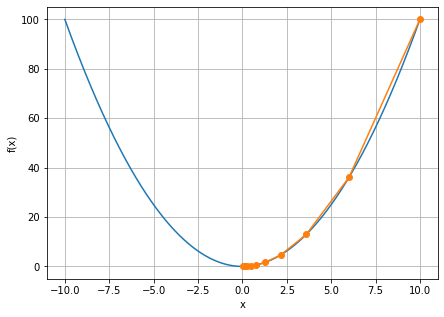

In [14]:
def show_trace(res):
    n = max(abs(min(res)), abs(max(res)))
    f_line = np.arange(-n, n, 0.01)
    d2l.set_figsize()
    d2l.plot([f_line, res], [[f(x) for x in f_line], [f(x) for x in res]],
             'x', 'f(x)', fmts=['-', '-o'])

show_trace(res)

##### Learning Rate
The learning rate $\eta$ can be set by the algorithm designer. If we use a learning rate that is too small, it will cause $x$ to update very slowly, requiring more iterations to get a better solution. To show what happens in such a case, consider the progress in the same optimization problem for $\eta = 0.05$. As we can see, even after 10 steps we are still very far from the optimal solution.

epoch 0, x: 9.0
epoch 1, x: 8.1
epoch 2, x: 7.289999999999999
epoch 3, x: 6.560999999999999
epoch 4, x: 5.9049
epoch 5, x: 5.31441
epoch 6, x: 4.782969
epoch 7, x: 4.3046720999999994
epoch 8, x: 3.8742048899999997
epoch 9, x: 3.4867844009999995


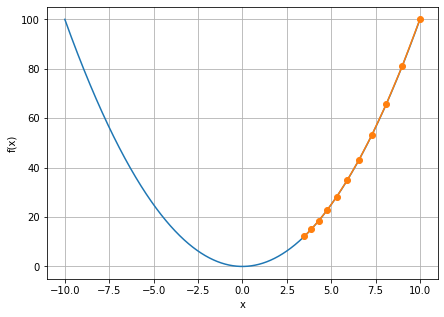

In [15]:
show_trace(gd(0.05))

Conversely, if we use an excessively high learning rate, $\left|\eta f'(x)\right|$ might be too large for the first-order Taylor expansion formula. That is, the term $\mathcal{O}(\eta^2 f'^2(x))$ in (`11.3.1`) might become significant. In this case, we cannot guarantee that the iteration of $x$ will be able to lower the value of $f(x)$. For example, when we set the learning rate to $\eta=1.1$, $x$ overshoots the optimal solution $x=0$ and gradually diverges.

epoch 0, x: -12.0
epoch 1, x: 14.400000000000002
epoch 2, x: -17.280000000000005
epoch 3, x: 20.736000000000008
epoch 4, x: -24.883200000000013
epoch 5, x: 29.859840000000023
epoch 6, x: -35.83180800000004
epoch 7, x: 42.998169600000054
epoch 8, x: -51.59780352000007
epoch 9, x: 61.917364224000096


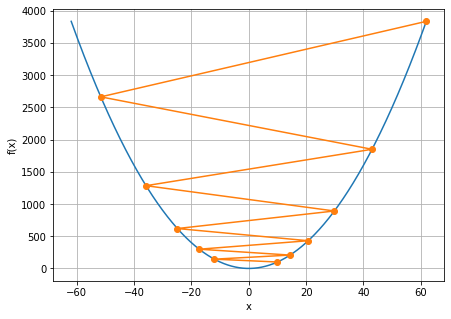

In [16]:
show_trace(gd(1.1))

##### Local Minima
To illustrate what happens for nonconvex functions consider the case of $f(x) = x \cdot \cos c x$. This function has infinitely many local minima. Depending on our choice of learning rate and depending on how well conditioned the problem is, we may end up with one of many solutions. The example below illustrates how an (unrealistically) high learning rate will lead to a poor local minimum.

epoch 0, x: 0.5752220392306207
epoch 1, x: -1.2065878533717997
epoch 2, x: -2.2795981343512657
epoch 3, x: -1.3434161011404435
epoch 4, x: -2.206769352661937
epoch 5, x: -1.4257892748995666
epoch 6, x: -2.154634042402581
epoch 7, x: -1.4838758970942854
epoch 8, x: -2.114353605255674
epoch 9, x: -1.528165927635083


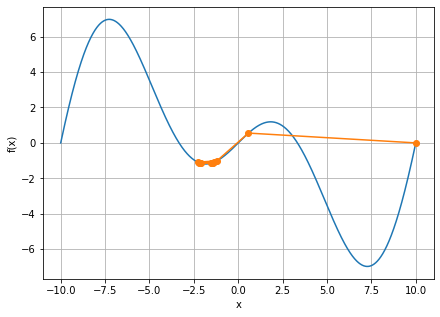

In [17]:
c = 0.15 * np.pi

def f(x):
    return x * np.cos(c * x)

def gradf(x):
    return np.cos(c * x) - c * x * np.sin(c * x)

show_trace(gd(2))

### 11.3.2 Multivariate Gradient Descent
Now that we have a better intuition of the univariate case, let us consider the situation where $\mathbf{x} \in \mathbb{R}^d$. That is, the objective function $f: \mathbb{R}^d \to \mathbb{R}$ maps vectors into scalars. Correspondingly its gradient is multivariate, too. It is a vector consisting of $d$ partial derivatives:

$$\nabla f(\mathbf{x}) = \bigg[\frac{\partial f(\mathbf{x})}{\partial x_1}, \frac{\partial f(\mathbf{x})}{\partial x_2}, \ldots, \frac{\partial f(\mathbf{x})}{\partial x_d}\bigg]^\top.$$

Each partial derivative element $\displaystyle\frac{\partial f(\mathbf{x})}{\partial x_i}$ in the gradient indicates the rate of change of $f$ at $\mathbf{x}$ with respect to the input $x_i$. As before in the univariate case we can use the corresponding Taylor approximation for multivariate functions to get some idea of what we should do. In particular, we have that

$$f(\mathbf{x} + \mathbf{\epsilon}) = f(\mathbf{x}) + \mathbf{\epsilon}^\top \nabla f(\mathbf{x}) + \mathcal{O}(|\mathbf{\epsilon}|^2).$$ 

In other words, up to second order terms in $\mathbf{\epsilon}$ the direction of steepest descent is given by the negative gradient $-\nabla f(\mathbf{x})$. Choosing a suitable learning rate $\eta > 0$ yields the prototypical gradient descent algorithm:

$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f(\mathbf{x}).$

To see how the algorithm behaves in practice let us construct an objective function $f(\mathbf{x})=x_1^2+2x_2^2$ with a two-dimensional vector $\mathbf{x} = [x_1, x_2]^\top$ as input and a scalar as output. The gradient is given by $\nabla f(\mathbf{x}) = [2x_1, 4x_2]^\top$. We will observe the trajectory of $\mathbf{x}$ by gradient descent from the initial position $[-5, -2]$. We need two more helper functions. The first uses an update function and applies it $20$ times to the initial value. The second helper visualizes the trajectory of $\mathbf{x}$.

In [18]:
#@save
def train_2d(trainer, steps=20):
    """Optimize a 2-dim objective function with a customized trainer."""
    # s1 and s2 are internal state variables and will
    # be used later in the chapter
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    return results

#@save
def show_trace_2d(f, results):
    """Show the trace of 2D variables during optimization."""
    d2l.set_figsize()
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
    d2l.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

Next, we observe the trajectory of the optimization variable $\mathbf{x}$ for learning rate $\eta = 0.1$. We can see that after 20 steps the value of $\mathbf{x}$ approaches its minimum at $[0, 0]$. Progress is fairly well-behaved albeit rather slow.

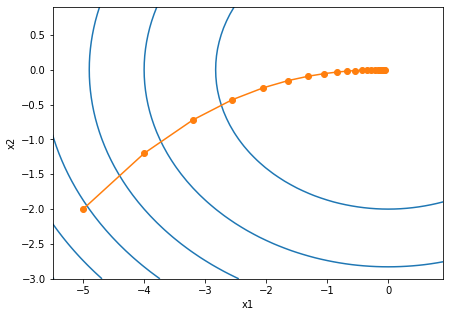

In [19]:
def f(x1, x2):
    return x1 ** 2 + 2 * x2 ** 2  # Objective

def gradf(x1, x2):
    return (2 * x1, 4 * x2)  # Gradient

def gd(x1, x2, s1, s2):
    (g1, g2) = gradf(x1, x2)  # Compute gradient
    return (x1 - eta * g1, x2 - eta * g2, 0, 0)  # Update variables

eta = 0.1
show_trace_2d(f, train_2d(gd))

### 11.3.3 Adaptive Methods
As we could see in `Section 11.3.1`, getting the learning rate $\eta$ "just right" is tricky. If we pick it too small, we make no progress. If we pick it too large, the solution oscillates and in the worst case it might even diverge. What if we could determine $\eta$ automatically or get rid of having to select a step size at all? Second order methods that look not only at the value and gradient of the objective but also at its curvature can help in this case. While these methods cannot be applied to deep learning directly due to the computational cost, they provide useful intuition into how to design advanced optimization algorithms that mimic many of the desirable properties of the algorithms outlined below.

##### Newton's Method
Reviewing the Taylor expansion of $f$ there is no need to stop after the first term. In fact, we can write it as

$$f(\mathbf{x} + \mathbf{\epsilon}) = f(\mathbf{x}) + \mathbf{\epsilon}^\top \nabla f(\mathbf{x}) + \frac{1}{2} \mathbf{\epsilon}^\top \nabla \nabla^\top f(\mathbf{x}) \mathbf{\epsilon} + \mathcal{O}(|\mathbf{\epsilon}|^3) \qquad (11.3.7).$$ 

To avoid cumbersome notation we define $H_f := \nabla \nabla^\top f(\mathbf{x})$ to be the Hessian of $f$. This is a $d \times d$ matrix. For small $d$ and simple problems $H_f$ is easy to compute. For deep networks, on the other hand, $H_f$ may be prohibitively large, due to the cost of storing $\mathcal{O}(d^2)$ entries. Furthermore it may be too expensive to compute via backprop as we would need to apply backprop to the backpropagation call graph. For now let us ignore such considerations and look at what algorithm we'd get.

After all, the minimum of $f$ satisfies $\nabla f(\mathbf{x}) = 0$. Taking derivatives of (`11.3.7`) with regard to $\mathbf{\epsilon}$ and ignoring higher order terms we arrive at

$$\nabla f(\mathbf{x}) + H_f \mathbf{\epsilon} = 0 \text{ and hence } \mathbf{\epsilon} = -H_f^{-1} \nabla f(\mathbf{x}).$$

That is, we need to invert the Hessian $H_f$ as part of the optimization problem.

For $f(x) = \frac{1}{2} x^2$ we have $\nabla f(x) = x$ and $H_f = 1$. Hence for any $x$ we obtain $\epsilon = -x$. In other words, a single step is sufficient to converge perfectly without the need for any adjustment! Alas, we got a bit lucky here since the Taylor expansion was exact. Let us see what happens in other problems.

epoch  0 , x: 8.00018159147481
epoch  1 , x: 6.0015227485135565
epoch  2 , x: 4.011398229022884
epoch  3 , x: 2.0825421834074804
epoch  4 , x: 0.5257631592168073
epoch  5 , x: 0.011785578458138435
epoch  6 , x: 1.3641603793801416e-07
epoch  7 , x: 1.852884572118782e-22
epoch  8 , x: 0.0
epoch  9 , x: 0.0


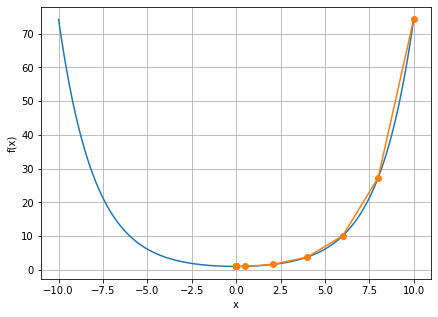

In [20]:
c = 0.5

def f(x):
    return np.cosh(c * x)  # Objective

def gradf(x):
    return c * np.sinh(c * x)  # Derivative

def hessf(x):
    return c**2 * np.cosh(c * x)  # Hessian

# Hide learning rate for now
def newton(eta=1):
    x = 10
    results = [x]
    for i in range(10):
        x -= eta * gradf(x) / hessf(x)
        results.append(x)
        print('epoch ', i, ', x:', x)
    return results

show_trace(newton())

Now let us see what happens when we have a nonconvex function, such as $f(x) = x \cos(c x)$. After all, note that in Newton's method we end up dividing by the Hessian. This means that if the second derivative is negative we would walk into the direction of increasing $f$. That is a fatal flaw of the algorithm. Let us see what happens in practice.

epoch  0 , x: 5.000000000000003
epoch  1 , x: 24.994879494194016
epoch  2 , x: 27.783105997122323
epoch  3 , x: 26.800099279328098
epoch  4 , x: 26.834178613689314
epoch  5 , x: 26.83413291332453
epoch  6 , x: 26.83413291324767
epoch  7 , x: 26.83413291324767
epoch  8 , x: 26.83413291324767
epoch  9 , x: 26.83413291324767


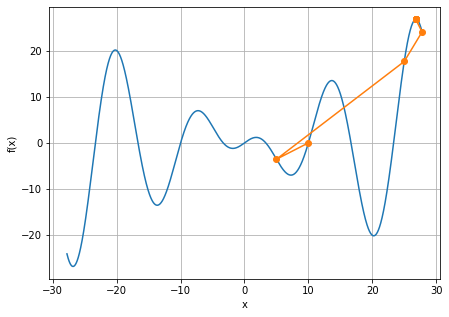

In [21]:
c = 0.15 * np.pi

def f(x):
    return x * np.cos(c * x)

def gradf(x):
    return np.cos(c * x) - c * x * np.sin(c * x)

def hessf(x):
    return - 2 * c * np.sin(c * x) - x * c**2 * np.cos(c * x)

show_trace(newton())

This went spectacularly wrong. How can we fix it? One way would be to "fix" the Hessian by taking its absolute value instead. Another strategy is to bring back the learning rate. This seems to defeat the purpose, but not quite. Having second order information allows us to be cautious whenever the curvature is large and to take longer steps whenever the objective is flat. Let us see how this works with a slightly smaller learning rate, say $\eta = 0.5$. As we can see, we have quite an efficient algorithm.

epoch  0 , x: 7.500000000000002
epoch  1 , x: 7.3871648802624845
epoch  2 , x: 7.329002380746055
epoch  3 , x: 7.2993923724814165
epoch  4 , x: 7.284441656516651
epoch  5 , x: 7.27692802722112
epoch  6 , x: 7.273161403549493
epoch  7 , x: 7.27127560859203
epoch  8 , x: 7.270332086428487
epoch  9 , x: 7.269860168684531


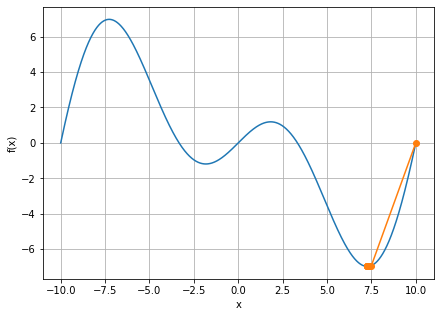

In [22]:
show_trace(newton(0.5))

### Convergence Analysis
We only analyze the convergence rate for convex and three times differentiable $f$, where at its minimum $x^*$ the second derivative is nonzero, i.e., where $f''(x^*) > 0$. The multivariate proof is a straightforward extension of the argument below and omitted since it doesn't help us much in terms of intuition.

Denote by $x_k$ the value of $x$ at the $k$-th iteration and let $e_k := x_k - x^*$ be the distance from optimality. By Taylor series expansion we have that the condition $f'(x^*) = 0$ can be written as

$$0 = f'(x_k - e_k) = f'(x_k) - e_k f''(x_k) + \frac{1}{2} e_k^2 f'''(\xi_k).$$

This holds for some $\xi_k \in [x_k - e_k, x_k]$. Recall that we have the update $x_{k+1} = x_k - f'(x_k) / f''(x_k)$. Dividing the above expansion by $f''(x_k)$ yields

$$e_k - f'(x_k) / f''(x_k) = \frac{1}{2} e_k^2 f'''(\xi_k) / f''(x_k).$$

Plugging in the update equations leads to the following bound $e_{k+1} \leq e_k^2 f'''(\xi_k) / f'(x_k)$. Consequently, whenever we are in a region of bounded $f'''(\xi_k) / f''(x_k) \leq c$, we have a quadratically decreasing error $e_{k+1} \leq c e_k^2$.

As an aside, optimization researchers call this *linear* convergence, whereas a condition such as $e_{k+1} \leq \alpha e_k$ would be called a *constant* rate of convergence.
Note that this analysis comes with a number of caveats: We do not really have much of a guarantee when we will reach the region of rapid convergence. Instead, we only know that once we reach it, convergence will be very quick. Second, this requires that $f$ is well-behaved up to higher order derivatives. It comes down to ensuring that $f$ does not have any "surprising" properties in terms of how it might change its values.

### Preconditioning
Quite unsurprisingly computing and storing the full Hessian is very expensive. It is thus desirable to find alternatives. One way to improve matters is by avoiding to compute the Hessian in its entirety but only compute the *diagonal* entries. While this is not quite as good as the full Newton method, it is still much better than not using it. Moreover, estimates for the main diagonal elements are what drives some of the innovation in stochastic gradient descent optimization algorithms. This leads to update algorithms of the form

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \mathrm{diag}(H_f)^{-1} \nabla \mathbf{x}.$$

To see why this might be a good idea consider a situation where one variable denotes height in millimeters and the other one denotes height in kilometers. Assuming that for both the natural scale is in meters we have a terrible mismatch in parameterizations. Using preconditioning removes this. Effectively preconditioning with gradient descent amounts to selecting a different learning rate for each coordinate.

### Gradient Descent with Line Search
One of the key problems in gradient descent was that we might overshoot the goal or make insufficient progress. A simple fix for the problem is to use line search in conjunction with gradient descent. That is, we use the direction given by $\nabla f(\mathbf{x})$ and then perform binary search as to which step length $\eta$ minimizes $f(\mathbf{x} - \eta \nabla f(\mathbf{x}))$.

This algorithm converges rapidly (for an analysis and proof see e.g., (`Boyd & Vandenberghe, 2004`)). However, for the purpose of deep learning this is not quite so feasible, since each step of the line search would require us to evaluate the objective function on the entire dataset. This is way too costly to accomplish.

##### Summary
* Learning rates matter. Too large and we diverge, too small and we do not make progress.
* Gradient descent can get stuck in local minima.
* In high dimensions adjusting the learning rate is complicated.
* Preconditioning can help with scale adjustment.
* Newton's method is a lot faster *once* it has started working properly in convex problems.
* Beware of using Newton's method without any adjustments for nonconvex problems.

##### Exercises
1. Experiment with different learning rates and objective functions for gradient descent.
2. Implement line search to minimize a convex function in the interval $[a, b]$.
    * Do you need derivatives for binary search, i.e., to decide whether to pick $[a, (a+b)/2]$ or $[(a+b)/2, b]$.
    * How rapid is the rate of convergence for the algorithm?
    * Implement the algorithm and apply it to minimizing $\log (\exp(x) + \exp(-2*x -3))$.
3. Design an objective function defined on $\mathbb{R}^2$ where gradient descent is exceedingly slow. Hint: scale different coordinates differently.
4. Implement the lightweight version of Newton's method using preconditioning:
    * Use diagonal Hessian as preconditioner.
    * Use the absolute values of that rather than the actual (possibly signed) values.
    * Apply this to the problem above.
5. Apply the algorithm above to a number of objective functions (convex or not). What happens if you rotate coordinates by $45$ degrees?


## 11.4 Stochastic Gradient Descent
In this section, we are going to introduce the basic principles of stochastic gradient descent.

### 11.4.1 Stochastic Gradient Updates
In deep learning, the objective function is usually the average of the loss functions for each example in the training dataset. We assume that $f_i(\mathbf{x})$ is the loss function of the training dataset with $n$ examples, an index of $i$, and parameter vector of $\mathbf{x}$, then we have the objective function

$$f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\mathbf{x}).$$

The gradient of the objective function at $\mathbf{x}$ is computed as

$$\nabla f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}).$$

If gradient descent is used, the computing cost for each independent variable iteration is $\mathcal{O}(n)$, which grows linearly with $n$. Therefore, when the model training dataset is large, the cost of gradient descent for each iteration will be very high.

Stochastic gradient descent (SGD) reduces computational cost at each iteration. At each iteration of stochastic gradient descent, we uniformly sample an index $i\in{1,\ldots, n}$ for data instances at random, and compute the gradient $\nabla f_i(\mathbf{x})$ to update $\mathbf{x}$:

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f_i(\mathbf{x}).$$

Here, $\eta$ is the learning rate. We can see that the computing cost for each iteration drops from $\mathcal{O}(n)$ of the gradient descent to the constant $\mathcal{O}(1)$. We should mention that the stochastic gradient $\nabla f_i(\mathbf{x})$ is the unbiased estimate of gradient $\nabla f(\mathbf{x})$.

$$\mathbb{E}i \nabla f_i(\mathbf{x}) = \frac{1}{n} \sum{i = 1}^n \nabla f_i(\mathbf{x}) = \nabla f(\mathbf{x}).$$

This means that, on average, the stochastic gradient is a good estimate of the gradient.

Now, we will compare it to gradient descent by adding random noise with a mean of 0 to the gradient to simulate a SGD.

epoch 50, x1 -0.522513, x2 0.085780


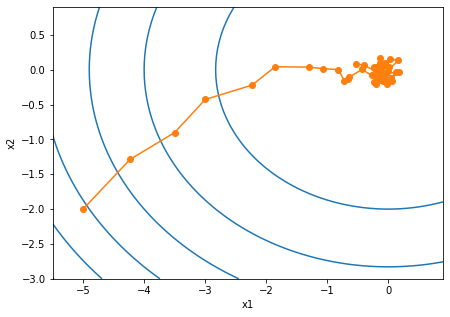

In [23]:
def f(x1, x2):
    return x1 ** 2 + 2 * x2 ** 2  # Objective

def gradf(x1, x2):
    return (2 * x1, 4 * x2)  # Gradient

def sgd(x1, x2, s1, s2):  # Simulate noisy gradient
    global lr  # Learning rate scheduler
    (g1, g2) = gradf(x1, x2)  # Compute gradient
    (g1, g2) = (g1 + np.random.normal(0.1), g2 + np.random.normal(0.1))
    eta_t = eta * lr()  # Learning rate at time t
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)  # Update variables

eta = 0.1
lr = (lambda: 1)  # Constant learning rate
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50))

As we can see, the trajectory of the variables in the SGD is much more noisy than the one we observed in gradient descent in the previous section. This is due to the stochastic nature of the gradient. That is, even when we arrive near the minimum, we are still subject to the uncertainty injected by the instantaneous gradient via $\eta \nabla f_i(\mathbf{x})$. Even after 50 steps the quality is still not so good. Even worse, it will not improve after additional steps (we encourage the reader to experiment with a larger number of steps to confirm this on his own). This leaves us with the only alternative---change the learning rate $\eta$. However, if we pick this too small, we will not make any meaningful progress initially. On the other hand, if we pick it too large, we will not get a good solution, as seen above. The only way to resolve these conflicting goals is to reduce the learning rate dynamically as optimization progresses.

This is also the reason for adding a learning rate function `lr` into the `sgd` step function. In the example above any functionality for learning rate scheduling lies dormant as we set the associated `lr` function to be constant, i.e., `lr = (lambda: 1)`.


### 11.4.2 Dynamic Learning Rate
Replacing $\eta$ with a time-dependent learning rate $\eta(t)$ adds to the complexity of controlling convergence of an optimization algorithm. In particular, need to figure out how rapidly $\eta$ should decay. If it is too quick, we will stop optimizing prematurely. If we decrease it too slowly, we waste too much time on optimization. There are a few basic strategies that are used in adjusting $\eta$ over time (we will discuss more advanced strategies in a later chapter):

$$ \begin{aligned} \eta(t) & = \eta_i \text{ if } t_i \leq t \leq t_{i+1} && \mathrm{piecewise~constant} \\ \eta(t) & = \eta_0 \cdot e^{-\lambda t} && \mathrm{exponential} \\ \eta(t) & = \eta_0 \cdot (\beta t + 1)^{-\alpha} && \mathrm{polynomial} \end{aligned} $$

In the first scenario we decrease the learning rate, e.g., whenever progress in optimization has stalled. This is a common strategy for training deep networks. Alternatively we could decrease it much more aggressively by an exponential decay. Unfortunately this leads to premature stopping before the algorithm has converged. A popular choice is polynomial decay with $\alpha = 0.5$. In the case of convex optimization there are a number of proofs which show that this rate is well behaved. Let us see what this looks like in practice.

epoch 1000, x1 -0.862200, x2 -0.019736


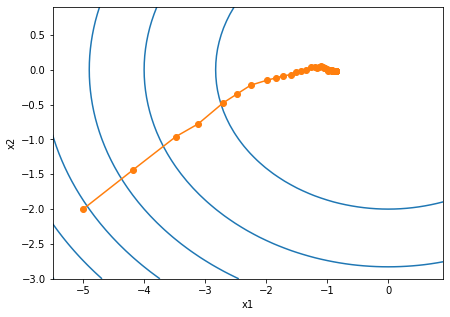

In [24]:
def exponential():
    global ctr
    ctr += 1
    return math.exp(-0.1 * ctr)

ctr = 1
lr = exponential  # Set up learning rate
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=1000))

As expected, the variance in the parameters is significantly reduced. However, this comes at the expense of failing to converge to the optimal solution $\mathbf{x} = (0, 0)$. Even after 1000 steps are we are still very far away from the optimal solution. Indeed, the algorithm fails to converge at all. On the other hand, if we use a polynomial decay where the learning rate decays with the inverse square root of the number of steps convergence is good.

epoch 50, x1 -0.024847, x2 0.090820


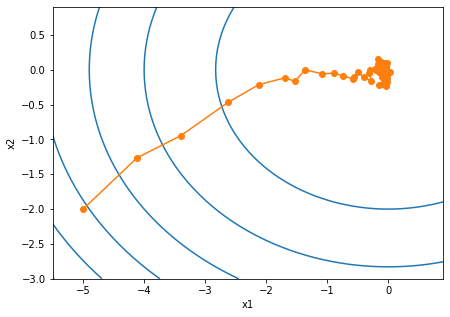

In [25]:
def polynomial():
    global ctr
    ctr += 1
    return (1 + 0.1 * ctr)**(-0.5)

ctr = 1
lr = polynomial  # Set up learning rate
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50))

There exist many more choices for how to set the learning rate. For instance, we could start with a small rate, then rapidly ramp up and then decrease it again, albeit more slowly. We could even alternate between smaller and larger learning rates. There exists a large variety of such schedules. For now let us focus on learning rate schedules for which a comprehensive theoretical analysis is possible, i.e., on learning rates in a convex setting. For general nonconvex problems it is very difficult to obtain meaningful convergence guarantees, since in general minimizing nonlinear nonconvex problems is NP hard. For a survey see e.g., the excellent [lecture notes of Tibshirani 2015](https://www.stat.cmu.edu/~ryantibs/convexopt-F15/lectures/26-nonconvex.pdf).

### 11.4.3 Convergence Analysis for Convex Objectives
The following is optional and primarily serves to convey more intuition about the problem. We limit ourselves to one of the simplest proofs, as described by (`Nesterov & Vial, 2000`). Significantly more advanced proof techniques exist, e.g., whenever the objective function is particularly well behaved. (`Hazan et al., 2008`) show that for strongly convex functions, i.e., for functions that can be bounded from below by $\mathbf{x}^\top \mathbf{Q} \mathbf{x}$, it is possible to minimize them in a small number of steps while decreasing the learning rate like $\eta(t) = \eta_0/(\beta t + 1)$. Unfortunately this case never really occurs in deep learning and we are left with a much more slowly decreasing rate in practice.

Consider the case where
$$\mathbf{w}_{t+1} = \mathbf{w}_{t} - \eta_t \partial_\mathbf{w} l(\mathbf{x}_t, \mathbf{w}).$$

In particular, assume that $\mathbf{x}_t$ is drawn from some distribution $P(\mathbf{x})$ and that $l(\mathbf{x}, \mathbf{w})$ is a convex function in $\mathbf{w}$ for all $\mathbf{x}$. Last denote by

$$R(\mathbf{w}) = E_{\mathbf{x} \sim P}[l(\mathbf{x}, \mathbf{w})]$$

the expected risk and by $R^*$ its minimum with regard to $\mathbf{w}$. Last let $\mathbf{w}^*$ be the minimizer (we assume that it exists within the domain which $\mathbf{w}$ is defined). In this case we can track the distance between the current parameter $\mathbf{w}_t$ and the risk minimizer $\mathbf{w}^*$ and see whether it improves over time:

$$\begin{aligned}
    \|\mathbf{w}_{t+1} - \mathbf{w}^*\|^2 & = \|\mathbf{w}_{t} - \eta_t \partial_\mathbf{w} l(\mathbf{x}_t, \mathbf{w}) - \mathbf{w}^*\|^2 \\
    & = \|\mathbf{w}_{t} - \mathbf{w}^*\|^2 + \eta_t^2 \|\partial_\mathbf{w} l(\mathbf{x}_t, \mathbf{w})\|^2 - 2 \eta_t
    \left\langle \mathbf{w}_t - \mathbf{w}^*, \partial_\mathbf{w} l(\mathbf{x}_t, \mathbf{w})\right\rangle.
   \end{aligned}
$$

The gradient $\partial_\mathbf{w} l(\mathbf{x}_t, \mathbf{w})$ can be bounded from above by some Lipschitz constant $L$, hence we have that

$$\eta_t^2 \|\partial_\mathbf{w} l(\mathbf{x}_t, \mathbf{w})\|^2 \leq \eta_t^2 L^2.$$

We are mostly interested in how the distance between $\mathbf{w}_t$ and $\mathbf{w}^*$ changes *in expectation*. In fact, for any specific sequence of steps the distance might well increase, depending on whichever $\mathbf{x}_t$ we encounter. Hence we need to bound the inner product. By convexity we have that

$$
l(\mathbf{x}_t, \mathbf{w}^*) \geq l(\mathbf{x}_t, \mathbf{w}_t) + \left\langle \mathbf{w}^* - \mathbf{w}_t, \partial_{\mathbf{w}} l(\mathbf{x}_t, \mathbf{w}_t) \right\rangle.
$$

Using both inequalities and plugging it into the above we obtain a bound on the distance between parameters at time $t+1$ as follows:

$$\|\mathbf{w}_{t} - \mathbf{w}^*\|^2 - \|\mathbf{w}_{t+1} - \mathbf{w}^*\|^2 \geq 2 \eta_t (l(\mathbf{x}_t, \mathbf{w}_t) - l(\mathbf{x}_t, \mathbf{w}^*)) - \eta_t^2 L^2.$$

This means that we make progress as long as the expected difference between current loss and the optimal loss outweighs $\eta_t L^2$. Since the former is bound to converge to $0$ it follows that the learning rate $\eta_t$ also needs to vanish.

Next we take expectations over this expression. This yields

$$E_{\mathbf{w}_t}\left[\|\mathbf{w}_{t} - \mathbf{w}^*\|^2\right] - E_{\mathbf{w}_{t+1}\mid \mathbf{w}_t}\left[\|\mathbf{w}_{t+1} - \mathbf{w}^*\|^2\right] \geq 2 \eta_t [E[R[\mathbf{w}_t]] - R^*] -  \eta_t^2 L^2.$$

The last step involves summing over the inequalities for $t \in \{t, \ldots, T\}$. Since the sum telescopes and by dropping the lower term we obtain

$$\|\mathbf{w}_{0} - \mathbf{w}^*\|^2 \geq 2 \sum_{t=1}^T \eta_t [E[R[\mathbf{w}_t]] - R^*] - L^2 \sum_{t=1}^T \eta_t^2.$$

Note that we exploited that $\mathbf{w}_0$ is given and thus the expectation can be dropped. Last define

$$\bar{\mathbf{w}} := \frac{\sum_{t=1}^T \eta_t \mathbf{w}_t}{\sum_{t=1}^T \eta_t}.$$

Then by convexity it follows that

$$\sum_t \eta_t E[R[\mathbf{w}_t]] \geq \sum \eta_t \cdot \left[E[\bar{\mathbf{w}}]\right].$$

Plugging this into the above inequality yields the bound

$$
\left[E[\bar{\mathbf{w}}]\right] - R^* \leq \frac{r^2 + L^2 \sum_{t=1}^T \eta_t^2}{2 \sum_{t=1}^T \eta_t}.
$$

Here $r^2 := \|\mathbf{w}_0 - \mathbf{w}^*\|^2$ is a bound on the distance between the initial choice of parameters and the final outcome. In short, the speed of convergence depends on how rapidly the loss function changes via the Lipschitz constant $L$ and how far away from optimality the initial value is $r$. Note that the bound is in terms of $\bar{\mathbf{w}}$ rather than $\mathbf{w}_T$. This is the case since $\bar{\mathbf{w}}$ is a smoothed version of the optimization path. Now let us analyze some choices for $\eta_t$.

* **Known Time Horizon**. Whenever $r, L$ and $T$ are known we can pick $\eta = r/L \sqrt{T}$. This yields as upper bound $r L (1 + 1/T)/2\sqrt{T} < rL/\sqrt{T}$. That is, we converge with rate $\mathcal{O}(1/\sqrt{T})$ to the optimal solution.
* **Unknown Time Horizon**. Whenever we want to have a good solution for *any* time $T$ we can pick $\eta = \mathcal{O}(1/\sqrt{T})$. This costs us an extra logarithmic factor and it leads to an upper bound of the form $\mathcal{O}(\log T / \sqrt{T})$.

Note that for strongly convex losses $l(\mathbf{x}, \mathbf{w}') \geq l(\mathbf{x}, \mathbf{w}) + \langle \mathbf{w}'-\mathbf{w}, \partial_\mathbf{w} l(\mathbf{x}, \mathbf{w}) \rangle + \frac{\lambda}{2} \|\mathbf{w}-\mathbf{w}'\|^2$ we can design even more rapidly converging optimization schedules. In fact, an exponential decay in $\eta$ leads to a bound of the form $\mathcal{O}(\log T / T)$.

## Stochastic Gradients and Finite Samples

So far we have played a bit fast and loose when it comes to talking about stochastic gradient descent. We posited that we draw instances $x_i$, typically with labels $y_i$ from some distribution $p(x, y)$ and that we use this to update the weights $w$ in some manner. In particular, for a finite sample size we simply argued that the discrete distribution $p(x, y) = \frac{1}{n} \sum_{i=1}^n \delta_{x_i}(x) \delta_{y_i}(y)$ allows us to perform SGD over it.

However, this is not really what we did. In the toy examples in the current section we simply added noise to an otherwise non-stochastic gradient, i.e., we pretended to have pairs $(x_i, y_i)$. It turns out that this is justified here (see the exercises for a detailed discussion). More troubling is that in all previous discussions we clearly did not do this. Instead we iterated over all instances exactly once. To see why this is preferable consider the converse, namely that we are sampling $n$ observations from the discrete distribution with replacement. The probability of choosing an element $i$ at random is $N^{-1}$. Thus to choose it at least once is

$$P(\mathrm{choose~} i) = 1 - P(\mathrm{omit~} i) = 1 - (1-N^{-1})^N \approx 1-e^{-1} \approx 0.63.$$

A similar reasoning shows that the probability of picking a sample exactly once is given by ${N \choose 1} N^{-1} (1-N^{-1})^{N-1} = \frac{N-1}{N} (1-N^{-1})^{N} \approx e^{-1} \approx 0.37$. This leads to an increased variance and decreased data efficiency relative to sampling without replacement. Hence, in practice we perform the latter (and this is the default choice throughout this book). Last note that repeated passes through the dataset traverse it in a *different* random order.


##### Summary
* For convex problems we can prove that for a wide choice of learning rates Stochastic Gradient Descent will converge to the optimal solution.
* For deep learning this is generally not the case. However, the analysis of convex problems gives us useful insight into how to approach optimization, namely to reduce the learning rate progressively, albeit not too quickly.
* Problems occur when the learning rate is too small or too large. In practice  a suitable learning rate is often found only after multiple experiments.
* When there are more examples in the training dataset, it costs more to compute each iteration for gradient descent, so SGD is preferred in these cases.
* Optimality guarantees for SGD are in general not available in nonconvex cases since the number of local minima that require checking might well be exponential.


##### Exercises

1. Experiment with different learning rate schedules for SGD and with different numbers of iterations. In particular, plot the distance from the optimal solution $(0, 0)$ as a function of the number of iterations.
1. Prove that for the function $f(x_1, x_2) = x_1^2 + 2 x_2^2$ adding normal noise to the gradient is equivalent to minimizing a loss function $l(\mathbf{x}, \mathbf{w}) = (x_1 - w_1)^2 + 2 (x_2 - w_2)^2$ where $x$ is drawn from a normal distribution.
    * Derive mean and variance of the distribution for $\mathbf{x}$.
    * Show that this property holds in general for objective functions $f(\mathbf{x}) = \frac{1}{2} (\mathbf{x} - \mathbf{\mu})^\top Q (\mathbf{x} - \mathbf{\mu})$ for $Q \succeq 0$.
1. Compare convergence of SGD when you sample from $\{(x_1, y_1), \ldots, (x_m, y_m)\}$ with replacement and when you sample without replacement.
1. How would you change the SGD solver if some gradient (or rather some coordinate associated with it) was consistently larger than all other gradients?
1. Assume that $f(x) = x^2 (1 + \sin x)$. How many local minima does $f$ have? Can you change $f$ in such a way that to minimize it one needs to evaluate all local minima?